<a href="https://colab.research.google.com/github/nanaagyei/sales-forecasting/blob/main/Sales_Forecasting_%26_Data_Enrichment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install -Uq upgini catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.3/432.3 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.1/286.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.9/913.9 kB 47.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━

**Prepare input data**

In [20]:
from os.path import exists
import pandas as pd


df_path = "train.csv.zip" if exists("train.csv.zip") else "https://github.com/upgini/upgini/raw/main/notebooks/train.csv.zip"
df = pd.read_csv(df_path)
df = df.sample(n=10_000, random_state=0)
df["store"] = df["store"].astype(str)
df["item"] = df["item"].astype(str)

df["date"] = pd.to_datetime(df["date"])

df.sort_values("date", inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,date,store,item,sales
0,2013-01-01,3,12,38
1,2013-01-01,4,9,19
2,2013-01-01,10,21,33
3,2013-01-01,3,27,11
4,2013-01-01,2,3,19


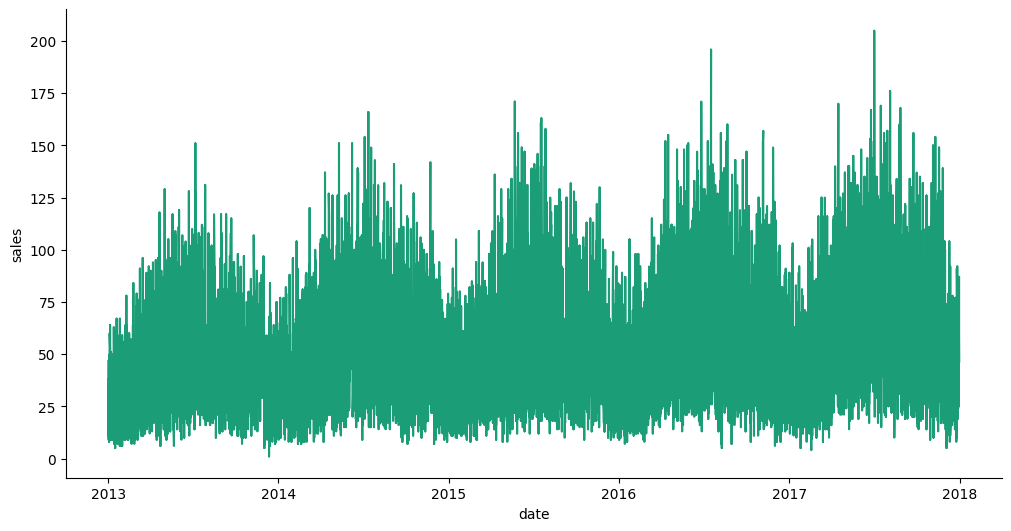

In [21]:
# @title Date vs Sales

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['sales']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('sales')

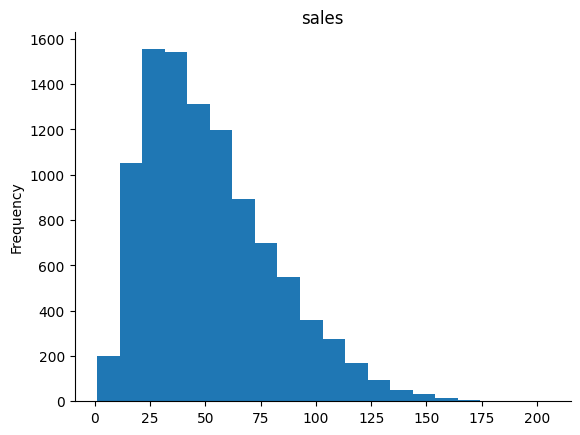

In [22]:
# @title Sales

from matplotlib import pyplot as plt
df['sales'].plot(kind='hist', bins=20, title='sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [23]:
train = df[df['date'] < "2017-01-01"]
test = df[df['date'] >= "2017-01-01"]

In [24]:
train_features = train.drop(columns=["sales"])
train_target = train["sales"]
test_features = test.drop(columns=["sales"])
test_target = test["sales"]

In [25]:
from upgini import FeaturesEnricher, SearchKey
from upgini.metadata import CVType

enricher = FeaturesEnricher(
    search_keys = {
        "date": SearchKey.DATE,
    },
    cv = CVType.time_series
)
enricher.fit(train_features,
             train_target,
             eval_set=[(test_features, test_target)])

[============================================================] 100% Finished


Try to add other keys like the COUNTRY, POSTAL_CODE, PHONE NUMBER, EMAIL/HEM, IPv4 to your training dataset
for search through all the available data sources.
See docs https://github.com/upgini/upgini#-total-239-countries-and-up-to-41-years-of-history
Detected task type: ModelTaskType.REGRESSION




Column name,Status,Errors
target,All valid,-
date,All valid,-



Running search request, search_id=97c0caaf-8a0e-4ff9-9431-378a5842e1fe
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com


51 relevant feature(s) found with the search keys: ['date']


f_weather_date_weather_umap_48_b39cd0c4,0.0661,100.0000,"5.1177, 4.7663, 4.6116",Upgini,Weather & climate normals data,Daily
f_autofe_div_cbf285e0,0.0149,100.0000,"0.9022, -1.0259, -1.0544",Upgini,"AutoFE: features from Calendar data,Markets data",Daily
f_autofe_div_0a5adf97,0.0149,100.0000,"0.3019, -0.238, 0.2147",Upgini,"AutoFE: features from Calendar data,Markets data",Daily
f_autofe_div_536f8702,0.0141,100.0000,"-1.0048, -0.7279, -0.9074",Upgini,"AutoFE: features from Calendar data,Markets data",Daily
f_weather_date_weather_pca_0_d7e0a1fc,0.0131,100.0000,"21.7177, 1.2874, 8.6327",Upgini,Weather & climate normals data,Daily
f_autofe_div_718f93e3,0.0116,100.0000,"-0.9558, 0.7866, 0.4245",Upgini,"AutoFE: features from Calendar data,Markets data",Daily
f_autofe_mul_16f51329,0.0103,100.0000,"0.9208, 1.1291, 0.7938",Upgini,"AutoFE: features from Calendar data,Markets data",Daily
f_autofe_div_a152c923,0.0103,100.0000,"-0.0029, 0.0016, 0.0023",Upgini,"AutoFE: features from Calendar data,Markets data",Daily
f_autofe_mul_6a97c336,0.0102,100.0000,"-0.907, -0.746, -1.0319",Upgini,"AutoFE: features from Calendar data,Markets data",Daily
f_weather_date_weather_umap_16_25ac8b87,0.0082,100.0000,"5.2217, 6.0784, 6.1553",Upgini,Weather & climate normals data,Daily
f_autofe_div_d64f05b5,0.0042,100.0000,"0.2183, 0.257, 0.2103",Upgini,AutoFE: features from Markets data,Daily


Upgini,"AutoFE: features from Calendar data,Markets data",0.1199,27
Upgini,Weather & climate normals data,0.0979,9
Upgini,AutoFE: features from Markets data,0.0086,5
Upgini,AutoFE: features from Calendar data,0.0043,5
Upgini,Markets data,0.0032,2
Upgini,Calendar data,0.0016,1
Upgini,AutoFE: feature from Markets data,0.0014,1
Upgini,World economic indicators,0.0007,1


"Calendar data,Markets data",f_autofe_div_cbf285e0,f_events_date_year_cos1_9014a856,f_financial_date_gold_7d_to_7d_1y_shift_a8127a43,/
"Calendar data,Markets data",f_autofe_div_0a5adf97,f_events_date_year_cos1_9014a856,f_financial_date_natural_gas_92dac942,/
"Calendar data,Markets data",f_autofe_div_536f8702,f_events_date_year_cos1_9014a856,f_financial_date_natural_gas_7d_to_1y_7a6f300d,/
"Calendar data,Markets data",f_autofe_div_718f93e3,f_events_date_week_sin1_847b5db1,f_financial_date_silver_1d_to_7d_f35d6e93,/
"Calendar data,Markets data",f_autofe_mul_16f51329,f_events_date_week_sin1_847b5db1,f_financial_date_gold_7d_to_7d_1y_shift_a8127a43,*
"Calendar data,Markets data",f_autofe_div_a152c923,f_events_date_year_cos1_9014a856,f_financial_date_stoxx_043cbcd4,/
"Calendar data,Markets data",f_autofe_mul_6a97c336,f_events_date_week_cos1_f6a8c1fc,f_financial_date_vix_7d_to_1y_634c77eb,*
Markets data,f_autofe_div_d64f05b5,f_financial_date_gold_7d_to_7d_1y_shift_a8127a43,f_financial_date_natural_gas_92dac942,/
"Calendar data,Markets data",f_autofe_mul_af6d166b,f_events_date_week_cos3_7525fe31,f_financial_date_vix_7d_to_1y_634c77eb,*
"Calendar data,Markets data",f_autofe_mul_25296268,f_events_date_week_sin1_847b5db1,f_financial_date_vix_7d_to_1y_634c77eb,*
"Calendar data,Markets data",f_autofe_mul_0cc09d2d,f_events_date_year_cos1_9014a856,f_financial_date_crude_oil_1f195998,*



Examples of outliers with maximum value of target:
40    205
24    196
46    176
Name: target, dtype: int64
Outliers will be excluded during the metrics calculation.
Calculating accuracy uplift after enrichment...

which makes metrics between the train and eval_set incomparable.


Train,7988,50.1955,311.6643,211.8864,99.7780
Eval 1,2012,59.4155,502.4146,386.4141,116.0005


In [26]:
from catboost import CatBoostRegressor
from catboost.utils import eval_metric

model = CatBoostRegressor(verbose=False, allow_writing_files=False, random_state=0)

enricher.calculate_metrics(
    train_features, train_target,
    eval_set = [(test_features, test_target)],
    estimator = model,
    scoring = "mean_absolute_percentage_error"
)

Calculating accuracy uplift after enrichment...
-
which makes metrics between the train and eval_set incomparable.


,Dataset type,Rows,Mean target,Baseline mean_absolute_percentage_error,Enriched mean_absolute_percentage_error,Uplift
0,Train,7988,50.1955,0.260691,0.169999,0.090692
1,Eval 1,2012,59.4155,0.265491,0.189804,0.075687


In [27]:
enriched_train_features = enricher.transform(train_features, keep_input=True)
enriched_test_features = enricher.transform(test_features, keep_input=True)
enriched_train_features

[============================================================] 100% Finished

You use Trial access to Upgini data enrichment. Limit for Trial: 10000 rows. You have already enriched: 0 rows.

Try to add other keys like the COUNTRY, POSTAL_CODE, PHONE NUMBER, EMAIL/HEM, IPv4 to your training dataset
for search through all the available data sources.
See docs https://github.com/upgini/upgini#-total-239-countries-and-up-to-41-years-of-history



Column name,Status,Errors
date,All valid,-



Running search request, search_id=18ba07af-9af9-470e-b144-351854c630d9
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com

Retrieving selected features from data sources...


[============================================================] 100% Finished

You use Trial access to Upgini data enrichment. Limit for Trial: 10000 rows. You have already enriched: 0 rows.

Try to add other keys like the COUNTRY, POSTAL_CODE, PHONE NUMBER, EMAIL/HEM, IPv4 to your training dataset
for search through all the available data sources.
See docs https://github.com/upgini/upgini#-total-239-countries-and-up-to-41-years-of-history



Column name,Status,Errors
date,All valid,-



Running search request, search_id=9c266623-c1e3-4e6b-9a3f-f5192997e944
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com

Retrieving selected features from data sources...


,date,store,item,f_weather_date_weather_umap_48_b39cd0c4,f_autofe_div_cbf285e0,f_autofe_div_0a5adf97,f_autofe_div_536f8702,f_weather_date_weather_pca_0_d7e0a1fc,f_autofe_div_718f93e3,f_autofe_mul_16f51329,...,f_economic_date_cbpol_pca_2_33d6e3fc,f_autofe_div_942365dd,f_autofe_div_48404110,f_weather_date_weather_umap_37_14cab469,f_autofe_div_1d266053,f_autofe_div_620077bb,f_autofe_mul_c40adfd2,f_autofe_mul_eb80198e,f_autofe_div_3d3952b2,f_autofe_mul_a4d34ac2
0,2013-01-01,3,12,4.540985,0.932536,0.294008,0.817451,29.676683,0.777123,0.826001,...,-0.938709,0.004323,1.279048,4.325118,-0.935870,0.837745,0.991189,-0.154330,0.585144,0.111666
1,2013-01-01,4,9,4.540985,0.932536,0.294008,0.817451,29.676683,0.777123,0.826001,...,-0.938709,0.004323,1.279048,4.325118,-0.935870,0.837745,0.991189,-0.154330,0.585144,0.111666
2,2013-01-01,10,21,4.540985,0.932536,0.294008,0.817451,29.676683,0.777123,0.826001,...,-0.938709,0.004323,1.279048,4.325118,-0.935870,0.837745,0.991189,-0.154330,0.585144,0.111666
3,2013-01-01,3,27,4.540985,0.932536,0.294008,0.817451,29.676683,0.777123,0.826001,...,-0.938709,0.004323,1.279048,4.325118,-0.935870,0.837745,0.991189,-0.154330,0.585144,0.111666
4,2013-01-01,2,3,4.540985,0.932536,0.294008,0.817451,29.676683,0.777123,0.826001,...,-0.938709,0.004323,1.279048,4.325118,-0.935870,0.837745,0.991189,-0.154330,0.585144,0.111666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7983,2016-12-30,8,19,4.534818,0.935360,0.260543,0.675974,27.967881,-0.425274,-0.459500,...,1.882764,0.004068,-0.800457,4.343112,-0.180609,1.223580,1.010638,-0.030464,-0.848981,0.105876
7984,2016-12-30,7,43,4.534818,0.935360,0.260543,0.675974,27.967881,-0.425274,-0.459500,...,1.882764,0.004068,-0.800457,4.343112,-0.180609,1.223580,1.010638,-0.030464,-0.848981,0.105876
7985,2016-12-31,1,37,4.427316,0.928794,0.265330,0.673678,27.412593,-0.971222,-1.037167,...,1.883887,0.004058,-0.841871,4.420162,0.505642,1.188089,0.991858,0.095949,-0.209551,0.110209
7986,2016-12-31,5,21,4.427316,0.928794,0.265330,0.673678,27.412593,-0.971222,-1.037167,...,1.883887,0.004058,-0.841871,4.420162,0.505642,1.188089,0.991858,0.095949,-0.209551,0.110209


In [28]:
model.fit(train_features, train_target)
preds = model.predict(test_features)
eval_metric(test_target.values, preds, "SMAPE")

[39.56447289695444]

In [29]:
model.fit(enriched_train_features, train_target)
enriched_preds = model.predict(enriched_test_features)
eval_metric(test_target.values, enriched_preds, "SMAPE")

[15.234616442825985]